## Brooklyn accessibility analysis


In [160]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
from scipy import stats
import contextily as ctx
from typing import Optional, Tuple, List, Dict

sns.set('notebook', font_scale=1.1, rc={'figure.figsize': (10, 5)})
sns.set_style('ticks', rc={'figure.facecolor': 'none', 'axes.facecolor': 'none'})
%config InlineBackend.figure_format = 'svg'

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

### 0. Load dataset and preprocessing

> **INFO**
> - `GEOID` is the unique identifier for every block


In [85]:
df_blocks['Population'].sum()

2576771.0

In [89]:
df_blocks[df_blocks['nycha'] == True]['Population'].sum() / df_blocks[df_blocks['nycha'] == True]['Area (m^2)'].sum()

0.022612814867075778

In [90]:
df_blocks[df_blocks['nycha'] == False]['Population'].sum() / df_blocks[df_blocks['nycha'] == False]['Area (m^2)'].sum()

0.013934725944561951

In [91]:
0.022612814867075778 / 0.013934725944561951 

1.6227671040707092

In [28]:
# Constants
CRS_VAL = 6933

In [29]:
# Load
df_pop = pd.read_csv('data/pop_count.csv')
df_blocks = gpd.read_file('data/bg_3_mo/bg_3_mo.shp')

# convert CRS to equal-area projection
# the length unit is now `meter`
df_blocks = df_blocks.to_crs(epsg=CRS_VAL)

# Preprocess
df_pop['GEOID'] = df_pop['GEOID'].str.split('US').str[1]

# Add population per census block group
df_blocks = pd.merge(df_blocks, df_pop[['GEOID', 'pop_tot']], on='GEOID', how='left')

df_blocks['trans_agg'] = df_blocks['num_bike'] + df_blocks['num_bus'] + df_blocks['num_bike']
df_blocks = df_blocks.rename(columns={'col_1': 'nycha', 'num_subs': 'Subway stations', 'num_bus': 'Bus stations', 
                                      'num_bike': 'Bike racks', 'pop_tot': 'Population'})

mapping_dict = {np.nan: False, 1: True}
df_blocks['nycha'] = df_blocks['nycha'].map(mapping_dict)

# Add area of census block groups
df_blocks['Area (m^2)'] = df_blocks.area
df_blocks['Area (km^2)'] = df_blocks.area.values/10e6

selected_columns = ['GEOID', 'Subway stations', 'Bus stations', 'Bike racks', 'nycha', 'Area (m^2)', 'Area (km^2)', 'Population', 'geometry']

df_blocks = df_blocks[selected_columns]

# Drop rows with missing population data
df_blocks = df_blocks.dropna(subset=['Population'], inplace=False)

df_blocks['Subway stations'].fillna(0, inplace=True)
df_blocks['Bus stations'].fillna(0, inplace=True)
df_blocks['Bike racks'].fillna(0, inplace=True)

map = gpd.read_file('data/nta/nynta2020.shp')
map = map.to_crs(CRS_VAL)
#use all bklyn ntas as boundary to clip the transit layers
nta_bk = map.loc[(map['BoroName']=='Brooklyn')]

In [5]:
df_blocks.shape

(2146, 9)

In [6]:
df_blocks.head()

GEOID  Subway stations  Bus stations  Bike racks  nycha  \
1  360470069022              0.0           0.0         1.0  False   
2  360470069011              1.0           0.0         1.0  False   
3  360470069021              0.0           0.0         0.0  False   
4  360470337011              0.0           1.0         2.0  False   
5  360470337021              0.0           0.0         0.0  False   

     Area (m^2)  Area (km^2)  Population  \
1  54967.459624     0.005497      1239.0   
2  33185.853036     0.003319       798.0   
3  49675.861242     0.004968       943.0   
4  49555.643605     0.004956      1293.0   
5  48904.271630     0.004890       815.0   

                                            geometry  
1  POLYGON ((-7139461.590 4774074.676, -7139445.1...  
2  POLYGON ((-7139107.003 4774170.216, -7139065.0...  
3  POLYGON ((-7139231.374 4773984.972, -7139189.8...  
4  POLYGON ((-7134939.471 4772597.616, -7134933.3...  
5  POLYGON ((-7134943.330 4772556.841, -7134941.4...

In [7]:
df_blocks['nycha'].value_counts()

nycha
False    2029
True      117
Name: count, dtype: int64

### 1. Aggregate accessibility analysis

> **RQ:** How does the public transportation accessibility in NYCHA neighborhoods compare to the average neighborhood in Brooklyn?


#### 1.1 Figures

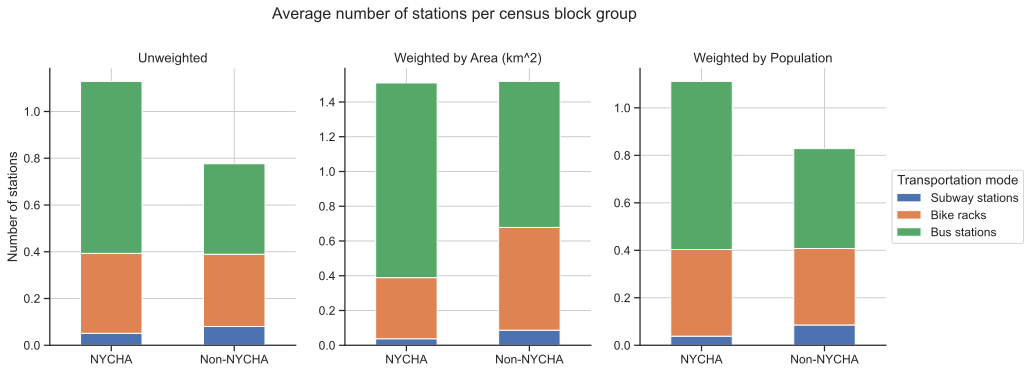

In [70]:
# Unweighted, Weighted by area, Weighted by population
def weighted_mean(ser: pd.Series, weight) -> float:
    weights = df_blocks.loc[ser.index, weight] if weight else None
    avg = np.average(ser, weights=weights)
    return avg

WEIGHTS = [None, 'Area (km^2)', 'Population']
VALUES = ["Subway stations", "Bike racks", "Bus stations"]

fig, axes = plt.subplots(nrows=1, ncols=len(WEIGHTS), figsize=(5 * len(WEIGHTS), 5))

for idx, weight in enumerate(WEIGHTS):
    df_blocks_plot = df_blocks.assign(
        nycha=df_blocks['nycha'].apply(lambda val: 'NYCHA' if val==1 else 'Non-NYCHA'),
    ).groupby(by=['nycha'])[VALUES].apply(
        lambda df: df.apply(
            lambda ser: weighted_mean(ser, weight=weight)
        )
    )
    display(df_blocks_plot.style.format(precision=2).set_caption(f'Weighted by {weight}' if weight is not None else "Unweighted"))
    df_blocks_plot.plot(
        kind='bar',
        stacked=True,
        ax=axes[idx],
        title=f'Weighted by {weight}' if weight is not None else "Unweighted",
        legend=False,
        rot=0,
        grid=True,
    )

fig.suptitle('Average number of stations per census block group', fontsize=16, y=1.05)
sns.despine()
axes[0].set_xlabel('')
axes[1].set_xlabel('')
axes[2].set_xlabel('')
axes[0].set_ylabel('Number of stations')
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), title='Transportation mode')
plt.show()

fig.savefig('figures/stacked_bar_agg.pdf', dpi=fig.dpi, bbox_inches='tight')

#### 1.2 Statistical testing

Compare:
1. $\mu_{\text{nycha}}$
2. $\mu_{\text{non-nycha}}$

Testing framework:
- **H0:** Number of transportation facilities of type X equal in Nycha neighbourhoods compared to non-Nycha neighbourhoods, that is, $\mu_{\text{nycha}} = \mu_{\text{non-nycha}}$

- **H1:** Not H0; $\mu_{\text{nycha}} \neq \mu_{\text{non-nycha}}$

Steps:
1. Compute average number of facilities (for comparable populations, in this case neighbourhoods)
2. Compute difference between average number of facilities, $\delta = \mu_{\text{nycha}} - \mu_{\text{non-nycha}}$
3. Assuming the number of facilities follow a normal distribution with the same variance for the Nycha and non-Nycha neighbourhoods, the hypothesis can be tested using a standard t-test (useful link: https://en.wikipedia.org/wiki/Student%27s_t-test)

We use https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html



In [62]:
# Separate by NYCHA and non-NYCHA
df_blocks_nycha = df_blocks[df_blocks['nycha'] == True]
df_blocks_non_nycha = df_blocks[df_blocks['nycha'] == False]

rng = np.random.default_rng()

def weighted_dist(ser: pd.Series, weight) -> float:
    weights = df_blocks.loc[ser.index, weight] if weight else None
    return weights

In [76]:
# Assuming equal variance (pooled)
VALUES = ["Subway stations", "Bike racks", "Bus stations"]

for value in VALUES:

    nycha_sample = df_blocks_nycha[value]
    non_nycha_sample = df_blocks_non_nycha[value]

    t_stat, p_val = stats.ttest_ind(nycha_sample, non_nycha_sample, equal_var=True)

    print(f'{value} | P-value: {p_val:.4}')

Subway stations | P-value: 0.2912
Bike racks | P-value: 0.6183
Bus stations | P-value: 1.343e-05


In [74]:
# Assuming different variance (Welch's)

for value in VALUES:

    nycha_sample = df_blocks_nycha[value]
    non_nycha_sample = df_blocks_non_nycha[value]

    t_stat, p_val = stats.ttest_ind(nycha_sample, non_nycha_sample, equal_var=False)

    print(f'{value} | P-value: {p_val:.4f}')

Subway stations | P-value: 0.1785
Bike racks | P-value: 0.6018
Bus stations | P-value: 0.0002



**Pooled standard deviations**

In [20]:
# Compute weighted standard deviations
def weighted_std(ser: pd.Series, weight=Optional[str]) -> float:
    weights = df_blocks.loc[ser.index, weight] if weight else None
    return np.sqrt(np.average((ser - ser.mean())**2, weights=weights))

WEIGHTS = [None, 'Area (km^2)', 'Population']
VALUES = ["Subway stations", "Bus stations", "Bike racks"]
for idx, weight in enumerate(WEIGHTS):
    display(
        df_blocks[VALUES].apply(
            lambda ser: weighted_std(ser, weight=weight)
        ).to_frame("Std.").style.format(precision=2).set_caption(f'Weighted by {weight}' if weight is not None else "Unweighted")
    )

### 2. Spatially localized accessibility analysis

In [38]:
# Add centroids
df_blocks['center_x'] = df_blocks.centroid.x
df_blocks['center_y'] = df_blocks.centroid.y

# Standardize coordinates
coords = df_blocks[['center_x', 'center_y']].values
scaler = StandardScaler()
coords_standardized = scaler.fit_transform(coords)

df_blocks['center_x_st'] = coords_standardized[:, 0]
df_blocks['center_y_st'] = coords_standardized[:, 1]

In [39]:
df_nycha = df_blocks[df_blocks['nycha'] == True]
df_non_nycha = df_blocks[df_blocks['nycha'] == False]

### 2.1 K-means clustering map

In [113]:
NUM_CLUSTERS = 8

In [114]:
coords = df_blocks[['center_x_st', 'center_y_st']].values
kmeans = KMeans(n_clusters=NUM_CLUSTERS, random_state=0).fit(coords)
df_blocks['kmeans_cluster'] = kmeans.labels_

In [115]:
df_blocks['kmeans_cluster'].value_counts()

kmeans_cluster
7    363
5    308
0    279
1    271
3    253
6    233
2    232
4    207
Name: count, dtype: int64

In [116]:
from matplotlib.colors import ListedColormap
custom_colors = sns.color_palette().as_hex()[:8]
# Create a ListedColormap using the defined colors
custom_cmap = ListedColormap(custom_colors)

In [117]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# MAP
nta_bk.plot(ax=axes[0], facecolor='none', edgecolor='lightgray')
ctx.add_basemap(ax=axes[0], crs=CRS_VAL, source=ctx.providers.CartoDB.Positron,alpha=0.9)

nta_bk.plot(ax=axes[1], facecolor='none', edgecolor='lightgray')
ctx.add_basemap(ax=axes[1], crs=CRS_VAL, source=ctx.providers.CartoDB.Positron,alpha=0.9)

axes[0].set_title(r'Brooklyn clusters ($K=8$)', fontsize=15)
df_blocks.plot(column='kmeans_cluster', cmap=custom_cmap, ax=axes[0], zorder=10,legend=True)

axes[1].set_title(r'NYCHA neighborhoods within clusters ($K=8$)', fontsize=15)
df_blocks[df_blocks['nycha'] == True].plot(column='kmeans_cluster', cmap=custom_cmap, ax=axes[1], zorder=10, legend=True)

axes[0].set_xticks([])
axes[0].set_yticks([])

axes[1].set_xticks([])
axes[1].set_yticks([])
plt.tight_layout()
fig.savefig('figures/kmeans_clusters_map.pdf', dpi=fig.dpi, bbox_inches='tight')

#### 2.2 Cluster analysis

In [142]:
EXCLUDE_CLUSTERS = [5]

# Cluster 5 does not have any NYCHA neighborhoods
df_blocks = df_blocks[df_blocks['kmeans_cluster'] != 5]

#### 1.2 Statistical testing

Compare:
1. $\mu_{\text{nycha}}$
2. $\mu_{\text{non-nycha}}$

Testing framework:
- **H0:** Number of transportation facilities of type X equal in Nycha neighbourhoods compared to non-Nycha neighbourhoods, that is, $\mu_{\text{nycha}} = \mu_{\text{non-nycha}}$

- **H1:** Not H0; $\mu_{\text{nycha}} \neq \mu_{\text{non-nycha}}$

Steps:
1. Compute average number of facilities (for comparable populations, in this case neighbourhoods)
2. Compute difference between average number of facilities, $\delta = \mu_{\text{nycha}} - \mu_{\text{non-nycha}}$
3. Assuming the number of facilities follow a normal distribution with the same variance for the Nycha and non-Nycha neighbourhoods, the hypothesis can be tested using a standard t-test (useful link: https://en.wikipedia.org/wiki/Student%27s_t-test)

We use https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html



In [178]:
df_cluster[df_cluster['nycha'] == True]['Population'].sum() 

51850.0


 Cluster 0
N_samples: 12 | nycha_pop: 19163.0 | Var_NYCHA: 0.0 | Var_non_NYCHA: 0.08621245914516969
Value: Subway stations | P-value: 0.0000 | p-value < 0.05: True
N_samples: 12 | nycha_pop: 19163.0 | Var_NYCHA: 0.0 | Var_non_NYCHA: 0.0
Value: Bike racks | P-value: nan | p-value < 0.05: False
N_samples: 12 | nycha_pop: 19163.0 | Var_NYCHA: 0.9097222222222223 | Var_non_NYCHA: 0.5262242421691986
Value: Bus stations | P-value: 0.9464 | p-value < 0.05: False



 Cluster 1
N_samples: 17 | nycha_pop: 28504.0 | Var_NYCHA: 0.0 | Var_non_NYCHA: 0.1744683489366979
Value: Subway stations | P-value: 0.0000 | p-value < 0.05: True
N_samples: 17 | nycha_pop: 28504.0 | Var_NYCHA: 0.5813148788927336 | Var_non_NYCHA: 0.6823888647777296
Value: Bike racks | P-value: 0.3285 | p-value < 0.05: False
N_samples: 17 | nycha_pop: 28504.0 | Var_NYCHA: 0.7197231833910034 | Var_non_NYCHA: 0.8038936077872154
Value: Bus stations | P-value: 0.7395 | p-value < 0.05: False



 Cluster 2
N_samples: 26 | nycha_pop: 43710.0 | Var_NYCHA: 0.10207100591715976 | Var_non_NYCHA: 0.09737015741351686
Value: Subway stations | P-value: 0.6059 | p-value < 0.05: False
N_samples: 26 | nycha_pop: 43710.0 | Var_NYCHA: 0.0 | Var_non_NYCHA: 0.009614478273164296
Value: Bike racks | P-value: 0.0789 | p-value < 0.05: False
N_samples: 26 | nycha_pop: 43710.0 | Var_NYCHA: 0.8698224852071006 | Var_non_NYCHA: 0.6841361108492789
Value: Bus stations | P-value: 0.9697 | p-value < 0.05: False



 Cluster 3
N_samples: 1 | nycha_pop: 1191.0 | Var_NYCHA: 0.0 | Var_non_NYCHA: 0.07306626354245405
Value: Subway stations | P-value: nan | p-value < 0.05: False
N_samples: 1 | nycha_pop: 1191.0 | Var_NYCHA: 0.0 | Var_non_NYCHA: 0.9018644494834971
Value: Bike racks | P-value: nan | p-value < 0.05: False
N_samples: 1 | nycha_pop: 1191.0 | Var_NYCHA: 0.0 | Var_non_NYCHA: 0.49464600655076846
Value: Bus stations | P-value: nan | p-value < 0.05: False



 Cluster 4
N_samples: 3 | nycha_pop: 8349.0 | Var_NYCHA: 0.0 | Var_non_NYCHA: 0.0048779315647827755
Value: Subway stations | P-value: 0.1593 | p-value < 0.05: False
N_samples: 3 | nycha_pop: 8349.0 | Var_NYCHA: 0.0 | Var_non_NYCHA: 0.0
Value: Bike racks | P-value: nan | p-value < 0.05: False
N_samples: 3 | nycha_pop: 8349.0 | Var_NYCHA: 1.5555555555555554 | Var_non_NYCHA: 1.161740676662822
Value: Bus stations | P-value: 0.7766 | p-value < 0.05: False



 Cluster 6
N_samples: 20 | nycha_pop: 38014.0 | Var_NYCHA: 0.04749999999999999 | Var_non_NYCHA: 0.09063457426877386
Value: Subway stations | P-value: 0.2376 | p-value < 0.05: False
N_samples: 20 | nycha_pop: 38014.0 | Var_NYCHA: 0.3275 | Var_non_NYCHA: 0.8971764861469287
Value: Bike racks | P-value: 0.0088 | p-value < 0.05: True
N_samples: 20 | nycha_pop: 38014.0 | Var_NYCHA: 0.8274999999999999 | Var_non_NYCHA: 0.4365976768277899
Value: Bus stations | P-value: 0.9263 | p-value < 0.05: False



 Cluster 7
N_samples: 38 | nycha_pop: 51850.0 | Var_NYCHA: 0.04986149584487535 | Var_non_NYCHA: 0.07806863905325442
Value: Subway stations | P-value: 0.3255 | p-value < 0.05: False
N_samples: 38 | nycha_pop: 51850.0 | Var_NYCHA: 0.6682825484764541 | Var_non_NYCHA: 0.4132544378698225
Value: Bike racks | P-value: 0.7760 | p-value < 0.05: False
N_samples: 38 | nycha_pop: 51850.0 | Var_NYCHA: 0.9702216066481991 | Var_non_NYCHA: 0.9190437869822485
Value: Bus stations | P-value: 0.9597 | p-value < 0.05: False


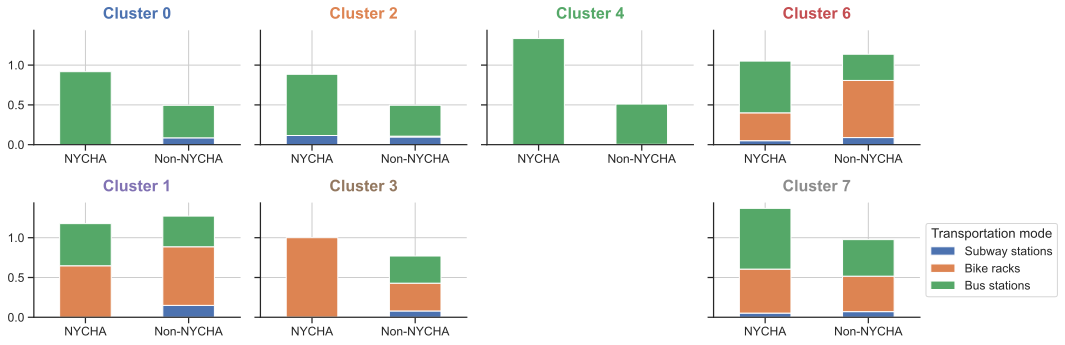

In [181]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

clusters_labels = [0, 1, 2, 3, 4, 6, 7]

# Assuming the rest of your code remains the same

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 5), sharey=True)

for cluster_i in clusters_labels:

    row = cluster_i % 2  # Calculate row index
    col = cluster_i // 2   # Calculate column index

    # Select data
    df_cluster = df_blocks[df_blocks['kmeans_cluster'] == cluster_i]
    def weighted_mean(ser: pd.Series, weight) -> float:
        weights = df_cluster.loc[ser.index, weight] if weight else None
        avg = np.average(ser, weights=weights)
        return avg
    
    VALUES = ["Subway stations", "Bike racks", "Bus stations"]

    print(f'\n Cluster {cluster_i}')
    for value in VALUES:
        # Perform t-test
        nycha_sample = df_cluster[df_cluster['nycha'] == True][value]
        non_nycha_sample = df_cluster[df_cluster['nycha'] == False][value]
        t_stat, p_val = stats.ttest_ind(nycha_sample, non_nycha_sample, equal_var=False, alternative='less')

        cluster_pop = df_cluster[df_cluster['nycha'] == True]['Population'].sum() 

        
        print(f'N_samples: {len(nycha_sample)} | nycha_pop: {cluster_pop} | Var_NYCHA: {np.var(nycha_sample)} | Var_non_NYCHA: {np.var(non_nycha_sample)}')
        print(f'Value: {value} | P-value: {p_val:.4f} | p-value < 0.05: {p_val < 0.05}')

    df_cluster_plot = df_cluster.assign(
        nycha=df_cluster['nycha'].apply(lambda val: 'NYCHA' if val==1 else 'Non-NYCHA'),
    ).groupby(by=['nycha'])[VALUES].apply(
        lambda df: df.apply(
            lambda ser: weighted_mean(ser, weight=None)
        )
    )
    display(df_cluster_plot.style.format(precision=2).set_caption(f'Weighted by {weight}' if weight is not None else "Unweighted"))
    df_cluster_plot.plot(
        kind='bar',
        stacked=True,
        ax=axes[row, col],
        title=f'Cluster {cluster_i}',
        legend=False,
        rot=0,
        grid=True,
    )

    axes[row, col].set_title(f'Cluster {cluster_i}', fontsize=16, y=1.05)
    sns.despine()
    axes[row, col].set_xlabel('')
    # Rest of your code...

# Set the title color for all axes
for idx, ax in enumerate(axes.flatten()):
    ax.title.set_color(custom_colors[idx])  
    ax.title.set_weight('bold') 

axes[1, 2].remove()
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), title='Transportation mode')
plt.tight_layout()
plt.show()
fig.savefig('figures/clusters_stacked_bar_graph.pdf', dpi=fig.dpi, bbox_inches='tight')
